### Data extraction
Extract data from MIMIC-III

In [1]:
import time
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cufflinks

cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [2]:
# Import pandas 
import pandas as pd 

start = time.time()
# reading csv file 
admissions_df = pd.read_csv("../../datasets/mmc-3/ADMISSIONS.csv")
noteevents_df = pd.read_csv("../../datasets/mmc-3/NOTEEVENTS.csv") 
end = time.time()
print(end - start)


/home/evan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.



32.06663465499878


In [3]:
start = time.time()
# Left join of two dataframes
note_admiss_df_left = noteevents_df.merge(admissions_df, on='HADM_ID', how='left', indicator=True)
end = time.time()
print(end - start)

3.9276835918426514


In [4]:
note_admiss_df_left[['DIAGNOSIS', 'SUBJECT_ID_x', 'SUBJECT_ID_y','DESCRIPTION', 'CATEGORY']]

,DIAGNOSIS,SUBJECT_ID_x,SUBJECT_ID_y,DESCRIPTION,CATEGORY
0,RT LOWER LOBE PNEUMONIA,22532,22532.0,Report,Discharge summary
1,CHRONIC OBSTRUCTIVE PULMONARY DISEASE,13702,13702.0,Report,Discharge summary
2,TRACHEALBRONCHEAL MALACEA/SDA,13702,13702.0,Report,Discharge summary
3,ASTHMA;COPD EXACERBATION,13702,13702.0,Report,Discharge summary
4,S/P FALL;TELEMETRY,26880,26880.0,Report,Discharge summary
...,...,...,...,...,...
2083175,NEWBORN,31097,31097.0,Report,Nursing/other
2083176,NEWBORN,31097,31097.0,Report,Nursing/other
2083177,NEWBORN,31097,31097.0,Report,Nursing/other
2083178,NEWBORN,31097,31097.0,Report,Nursing/other


In [5]:
pneumonia_df = note_admiss_df_left.loc[note_admiss_df_left["DIAGNOSIS"] == 'PNEUMONIA', ['ROW_ID_x', 'SUBJECT_ID_x', 'HADM_ID', 'CHARTDATE', 'CHARTTIME', 'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'DIAGNOSIS', 'HAS_CHARTEVENTS_DATA']]

In [6]:
#pneumonia_no_disch_df = pneumonia_df.loc[pneumonia_df["CATEGORY"] != 'Discharge summary', ['ROW_ID_x', 'SUBJECT_ID_x', 'HADM_ID', 'CHARTDATE', 'CHARTTIME', 'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'DIAGNOSIS', 'HAS_CHARTEVENTS_DATA']]
pneumonia_no_disch_df = pneumonia_df.loc[pneumonia_df["CATEGORY"] != 'Discharge summary', ['ROW_ID_x','SUBJECT_ID_x','CHARTDATE','STORETIME','CATEGORY','DESCRIPTION','TEXT', 'DEATHTIME']]

In [7]:
pneumonia_alive_no_disch = pneumonia_no_disch_df[pneumonia_no_disch_df.DEATHTIME.isnull()]
pneumonia_dead_no_disch = pneumonia_no_disch_df[pneumonia_no_disch_df.DEATHTIME.notnull()]

In [8]:
pneumonia_dead_no_disch.shape

(11895, 8)

In [9]:
pneumonia_alive_no_disch.shape

(46134, 8)

In [10]:
pneumonia_alive_no_disch = pneumonia_alive_no_disch.sort_values(by=['SUBJECT_ID_x','CHARTDATE', 'ROW_ID_x'])
pneumonia_dead_no_disch = pneumonia_dead_no_disch.sort_values(by=['SUBJECT_ID_x','CHARTDATE', 'ROW_ID_x'])

In [11]:
# Number of patients
pneumonia_dead_no_disch['SUBJECT_ID_x'].nunique()

252

In [12]:
# Number of patients
pneumonia_alive_no_disch['SUBJECT_ID_x'].nunique()

1167

In [13]:
# import text handling tool
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from collections import Counter

import sys
import re
import csv
import os.path

# define constants
# RESULT_HEADER = "WORD, FREQUENCY\n"
MIN_SEQ_LEN = 4
USE_1_N_SEQ = 2


# words that do not have meaning (can be modified later)
USELESS_WORDS = ["a", "the", "he", "she", ",", ".", "?", "!", ":", ";", "+", "*", "**"\
                 "your", "you"]

# count up the frequency of every word in every disease file
stemmer = PorterStemmer()
# create set of words to ignore in text
stop_words = set(stopwords.words('english'))

for word in USELESS_WORDS:
    stop_words.add(word)

In [14]:

#----------
def count_notes_per_patient(disease_df):
    patient_id_to_num_notes = {}
    patient_id = -1
    note_counter = 0
            
    for index, row in tqdm(disease_df.iterrows(), total=disease_df.shape[0]):
        patient_id_check = int(row['SUBJECT_ID_x'])
                
        if not patient_id == patient_id_check:
            patient_id_to_num_notes[patient_id] = note_counter
            note_counter = 1
        else:
            note_counter += 1
                    
        patient_id = patient_id_check
                
    patient_id_to_num_notes[patient_id] = note_counter
    del patient_id_to_num_notes[-1]
    return patient_id_to_num_notes

patient_id_to_num_notes = {}
patient_id_to_num_notes['pneumonia_dead'] = count_notes_per_patient(pneumonia_dead_no_disch)
patient_id_to_num_notes['pneumonia_alive'] = count_notes_per_patient(pneumonia_alive_no_disch)

100%|██████████| 46134/46134 [00:04<00:00, 10009.22it/s]


In [15]:
patient_id_to_num_notes

{'pneumonia_dead': {111: 12,
  346: 25,
  404: 3,
  546: 6,
  618: 16,
  705: 15,
  726: 48,
  1039: 55,
  1556: 37,
  1872: 3,
  1944: 56,
  2286: 69,
  2990: 166,
  3055: 29,
  3099: 13,
  3201: 8,
  3526: 7,
  3773: 6,
  3881: 20,
  4122: 51,
  4754: 101,
  4811: 21,
  5476: 1,
  5494: 22,
  5774: 104,
  5786: 152,
  5913: 1,
  6133: 68,
  6735: 13,
  6745: 13,
  6973: 36,
  6981: 8,
  7277: 66,
  7310: 8,
  7924: 9,
  7977: 9,
  9908: 11,
  9984: 15,
  10302: 100,
  10510: 86,
  10545: 10,
  10642: 10,
  11049: 14,
  11209: 9,
  11395: 41,
  12530: 24,
  12849: 50,
  13098: 46,
  13566: 23,
  14125: 9,
  14514: 96,
  14965: 25,
  15159: 15,
  15251: 11,
  15396: 17,
  15566: 37,
  15853: 45,
  16275: 17,
  16344: 27,
  16622: 51,
  16684: 29,
  17122: 16,
  17354: 5,
  17802: 64,
  17983: 65,
  18094: 23,
  18736: 35,
  18768: 46,
  18848: 205,
  18971: 26,
  19243: 25,
  19323: 6,
  19390: 21,
  19463: 20,
  19535: 59,
  19754: 13,
  19827: 22,
  19833: 58,
  19872: 10,
  20006: 8

In [16]:
print(len(patient_id_to_num_notes['pneumonia_dead']))
print(len(patient_id_to_num_notes['pneumonia_alive']))

252
1167


In [17]:
pneumonia_dead_no_disch.loc[pneumonia_dead_no_disch["SUBJECT_ID_x"] == 111, ['ROW_ID_x','SUBJECT_ID_x','DESCRIPTION','TEXT', 'DEATHTIME']]

,ROW_ID_x,SUBJECT_ID_x,DESCRIPTION,TEXT,DEATHTIME
70391,70124,111,Report,PATIENT/TEST INFORMATION:\nIndication: s/p PEA...,2144-07-01 14:55:00
142529,151749,111,Report,Compared to the previous tracing QRS voltage i...,2144-07-01 14:55:00
142097,151750,111,Report,"Normal sinus rhythm, rate 80. Biatrial abnorm...",2144-07-01 14:55:00
142303,151751,111,Report,Normal sinus rhythm. Q waves in leads V1-V2 c...,2144-07-01 14:55:00
380576,375732,111,Physician Resident Admission Note,Chief Complaint: respiratory distress\n HPI...,2144-07-01 14:55:00
380109,375744,111,ICU Event Note,Clinician: Nurse\n Pt admitted from the ED ...,2144-07-01 14:55:00
379907,375749,111,Physician Resident/Attending Admission Note - ...,Chief Complaint: respiratory distress\n HPI...,2144-07-01 14:55:00
379806,375753,111,Social Work Admission Note,Social Work Initial Note:\n Family Informati...,2144-07-01 14:55:00
379909,375760,111,ICU Event Note,TITLE:\n Clinician: Resident\n Patient ex...,2144-07-01 14:55:00
1066971,1079317,111,CHEST (PORTABLE AP),[**2144-7-1**] 2:43 AM\n CHEST (PORTABLE AP) ...,2144-07-01 14:55:00


In [18]:
def count_words_per_patient(disease_df, patient_id_to_num_notes):
    note_appearance_counter = {}
    number_of_patients = 0 # number of patients
    note_counter = 0

# -----------
    patient_id = -1
    word_set = set()
    note_event_counter = 0

    # Iterate through each note
    for index, row in tqdm(disease_df.iterrows(), total=disease_df.shape[0]):

        
        patient_id_check = int(row['SUBJECT_ID_x'])
    
        # if patient id has changed, end sequence and start new sequence
        if not patient_id == patient_id_check:
            number_of_patients += 1
            note_event_counter = 0
        
            for word in word_set:
                if word in note_appearance_counter:
                    note_appearance_counter[word] += 1
                else:
                    note_appearance_counter[word] = 1

        
            # reset word_set
            word_set = set()
        
        # update patient id
        patient_id = patient_id_check

            
        if patient_id_to_num_notes[patient_id_check] <= MIN_SEQ_LEN:
            continue
            
        if note_event_counter < patient_id_to_num_notes[patient_id] // USE_1_N_SEQ:
            note_event_counter += 1
            continue
                
        note_counter += 1
        note = re.sub(r'\[\*\*(.*?)\*\*\]|[_,\d\*:~=\.\-\+\\/]+', ' ', row['TEXT'])
        tokenized_note = word_tokenize(note)
        
        
        for word in tokenized_note:
            stemmed_word = stemmer.stem(word.lower())
            if not stemmed_word in stop_words:
                word_set.add(stemmed_word)
    
    print(str(note_counter) + " note events")
    print("finished counting frequent words for patients!")
#     return note_counter, note_appearance_counter
    return number_of_patients, note_appearance_counter

# variable dictionaries
number_of_notes = {}
note_appearance_counter = {}

number_of_notes['pneumonia_dead'], note_appearance_counter['pneumonia_dead'] = count_words_per_patient(pneumonia_dead_no_disch, patient_id_to_num_notes['pneumonia_dead'])
number_of_notes['pneumonia_alive'], note_appearance_counter['pneumonia_alive'] = count_words_per_patient(pneumonia_alive_no_disch, patient_id_to_num_notes['pneumonia_alive'])

  0%|          | 81/46134 [00:00<00:56, 808.60it/s]

5989 note events
finished counting frequent words for patients!


100%|██████████| 46134/46134 [02:42<00:00, 283.37it/s]

23172 note events
finished counting frequent words for patients!


In [19]:
number_of_notes

{'pneumonia_dead': 252, 'pneumonia_alive': 1167}

In [20]:
print(note_appearance_counter)

{'pneumonia_dead': {'copd': 45, 'region': 80, 'po': 143, 'yo': 75, 'lymph': 71, 'funer': 16, 'shock': 66, 'intub': 147, 'nodular': 15, 'ptx': 24, 'x': 185, 'rebound': 8, 'distend': 108, 'unchang': 179, '[': 80, 'cm': 141, 'view': 119, 'cultur': 100, 'azotemia': 6, 'proxi': 40, 'copi': 13, 'team': 141, 'e': 64, 'work': 87, 'arrang': 21, 'review': 135, 'involv': 85, 'tip': 126, 'hilar': 36, 'use': 112, 'metabol': 52, 'cathet': 130, 'elev': 122, 'morn': 93, 'l': 171, 'chang': 222, 'termin': 88, 'tf': 110, 'promin': 65, 'titl': 38, 'prepar': 21, 'data': 132, 'physic': 72, 'exchang': 20, 'offer': 47, 'continu': 176, 'emphas': 19, 'addendum': 98, 'complaint': 68, 'band': 44, 'renal': 107, 'anterior': 62, 'product': 99, 'mass': 65, 'record': 46, 'vital': 80, 'albuterol': 58, 'short': 86, 'mmol': 49, 'would': 127, 'glycem': 62, 'dextros': 11, 'ischem': 31, 'retrocardiac': 50, 'hcp': 52, 'breath': 162, 'ca': 105, 'mosf': 3, 'balanc': 85, 'aris': 6, 'regular': 66, 'nc': 62, 'etiolog': 57, 'ceftr

In [21]:
# # get hyper-paramters n_fold and threshold from user input
n_fold = float(3)
threshold = float(0.01)

frequent_word_lists = {}
factor = {}

In [22]:
"""function description:
for each disease in note_appearance_counter
    1. checks whether a word in disease file is frequent(frequency standard as defined by factor, n_fold, and threshold)
    2. adds to frequent_word_list
"""

# def find_frequent_word(note_appearance_counter, frequent_word_lists, number_of_notes, factor, n_fold, threshold):

# calculate normalizing factor for each disease
note_sum = 0

# Count from two labels
for disease in number_of_notes:
    note_sum += float(number_of_notes[disease])
    
for disease in number_of_notes:
    factor[disease] = number_of_notes[disease] / note_sum

# determine frequent word for each disease file
for disease in note_appearance_counter:
    frequent_word_lists[disease] = []

    print(disease + " has " + str(len(note_appearance_counter[disease])) + " unique words!")

    for word in note_appearance_counter[disease]:
        
        freq_check = True
        for check_disease in note_appearance_counter:
            
            if not disease == check_disease:
                if word in note_appearance_counter[check_disease]:
                    if not (note_appearance_counter[disease][word] / note_appearance_counter[check_disease][word] / factor[disease] * factor[check_disease] > n_fold \
                        and note_appearance_counter[disease][word] > (number_of_notes[disease] * threshold)):

                        freq_check = False
                        break

                else:
                    if not (note_appearance_counter[disease][word] > n_fold and note_appearance_counter[disease][word] > (number_of_notes[disease] * threshold)):
                        freq_check = False
                        break
        if freq_check:
            frequent_word_lists[disease].append((word))
            # Create a tuple of word and its count
#             frequent_word_lists[disease].append((word, note_appearance_counter[disease][word]))

        

print("finished making frequent words list for " + disease)

pneumonia_dead has 11678 unique words!
pneumonia_alive has 22572 unique words!
finished making frequent words list for pneumonia_alive


In [23]:
print(note_sum)
print(factor)

# number of notes
# 58029.0
# {'pneumonia_dead': 0.2049837150390322, 'pneumonia_alive': 0.7950162849609678}

1419.0
{'pneumonia_dead': 0.17758985200845667, 'pneumonia_alive': 0.8224101479915433}


In [24]:
print(len(frequent_word_lists['pneumonia_dead']))
print(len(frequent_word_lists['pneumonia_alive']))


# n_fold = float(3) threshold = float(0.01)
# 454
# 329

# n_fold = float(2) threshold = float(0.01)
# 914
# 600

# n_fold = float(1) threshold = float(0.01)
# 3320
# 2196

454
329


In [25]:
print(frequent_word_lists)

{'pneumonia_dead': ['funer', 'azotemia', 'arrang', 'unrespons', 'arrest', 'profound', 'vasopressin', 'cremat', 'acidem', 'hypercapnia', 'clergi', 'hypercapn', 'suffer', 'elig', 'pcv', 'hypothermia', 'bicarbon', 'expir', 'cpr', 'park', 'autopeep', 'death', 'anur', 'norepinephrin', 'clinician', 'refractori', 'mottl', 'phenylephrin', 'dic', 'recruit', 'paralyt', 'pea', 'sluggish', 'nonpurpos', 'virtual', 'dni', 'dnr', 'slough', 'lubric', 'pinpoint', 'gum', 'dk', 'cmo', 'nacl', 'oder', 'float', 'wish', 'mso', 'clariti', 'levoph', 'antb', 'dead', 'peerla', 'option', 'respon', 'hypotent', 'priest', 'bow', 'institut', 'pronounc', 'purpl', 'suport', 'dd', 'prognosi', 'grim', 'remin', 'viabl', 'gather', 'bye', 'asystol', 'mad', 'centimet', 'acv', 'synch', 'life', 'agreement', 'mortem', 'aprv', 'depth', 'moniotr', 'througout', 'hover', 'ppn', 'peac', 'duski', 'surviv', 'cathol', 'sync', 'nrbm', 'chaplain', 'mgx', 'jerk', 'corneal', 'cvvhdf', 'seriou', 'hemothorax', 'rusti', 'pulseless', 'vasopre

### 2. Co-occurrence generation
FP-growth

In [26]:
FREQUENT_WORD_LIST = frequent_word_lists['pneumonia_dead'] + frequent_word_lists['pneumonia_alive']
print(len(FREQUENT_WORD_LIST))
print(len(set(FREQUENT_WORD_LIST)))

783
783


In [27]:
"""function description:
generates frequent word set for the disease
"""
word_dict = {}
word_id = 1
stemmer = PorterStemmer()


for word in FREQUENT_WORD_LIST:
    if not word == "WORD":
        word_dict[stemmer.stem(word.strip())] = word_id
        word_id += 1
             
print(f"\nword dictionary created! Length: {len(word_dict)}\n")
print(word_dict)



word dictionary created! Length: 783

{'funer': 1, 'azotemia': 2, 'arrang': 3, 'unrespon': 4, 'arrest': 5, 'profound': 6, 'vasopressin': 7, 'cremat': 8, 'acidem': 9, 'hypercapnia': 10, 'clergi': 11, 'hypercapn': 12, 'suffer': 13, 'elig': 14, 'pcv': 15, 'hypothermia': 16, 'bicarbon': 17, 'expir': 18, 'cpr': 19, 'park': 20, 'autopeep': 21, 'death': 22, 'anur': 23, 'norepinephrin': 24, 'clinician': 25, 'refractori': 26, 'mottl': 27, 'phenylephrin': 28, 'dic': 29, 'recruit': 30, 'paralyt': 31, 'pea': 32, 'sluggish': 33, 'nonpurpo': 34, 'virtual': 35, 'dni': 36, 'dnr': 37, 'slough': 38, 'lubric': 39, 'pinpoint': 40, 'gum': 41, 'dk': 42, 'cmo': 43, 'nacl': 44, 'oder': 45, 'float': 46, 'wish': 47, 'mso': 48, 'clariti': 49, 'levoph': 50, 'antb': 51, 'dead': 52, 'peerla': 53, 'option': 54, 'respon': 55, 'hypot': 56, 'priest': 57, 'bow': 58, 'institut': 59, 'pronounc': 60, 'purpl': 61, 'suport': 62, 'dd': 63, 'prognosi': 64, 'grim': 65, 'remin': 66, 'viabl': 67, 'gather': 68, 'bye': 69, 'asysto

### Implementetion with python for FP_growth

### Count co-occurrences per patient

In [28]:
import os
import operator
from pathlib import Path
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd
import math

# ----
def fp_growth_input_per_patient_python(disease_df, word_dict, min_support):
    
    # For dataframe
    patient_cooc_dict = {}
    patient_node_dict = {}
    patient_note_cnt = {}
    
    # --------------    
    patient_id = -1
    note_cnt = 0
    patient_note_list = []
    
    # read line in from file (each line is one note)
    for index, row in tqdm(disease_df.iterrows(), total=disease_df.shape[0]):
        
        # only regard certain type of notes
        patient_id_check = int(row['SUBJECT_ID_x'])
        note = re.sub(r'\[\*\*(.*?)\*\*\]|[_,\d\*:~=\.\-\+\\/]+', ' ', row['TEXT'])
        patient_word_set = set()
    
#         print(f"patient_id_check: {patient_id_check}, patient_id: {patient_id}")
        # if patient id has changed, end sequence and start new sequence
        if not patient_id == patient_id_check and not patient_id == -1:
            te = TransactionEncoder()
            te_ary = te.fit(patient_note_list).transform(patient_note_list)
            df = pd.DataFrame(te_ary, columns=te.columns_)
            df_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
            
            cooc_tmp = []
            cooc_minsup_tmp = []
            node_minsup_tmp = []
            cooc_node_idx_tmp = []
            
            for index, row in df_itemsets.iterrows():
                if len(row['itemsets']) == 1:
                    word = list(row['itemsets'])[0]
                    min_sup = row['support']

                    node_minsup_tmp.append(len(patient_note_list) * row['support'])
                    cooc_node_idx_tmp.append(word)
                    
                if len(row['itemsets']) == 2:
                    cooc_ = sorted(list(row['itemsets']))
                    cooc_tmp.append(cooc_)
                    cooc_minsup_tmp.append(len(patient_note_list) * row['support'])
            
            cooc_dict = {}

            for num, i in enumerate(cooc_tmp):
                if tuple(i) not in cooc_dict:
                    cooc_dict[tuple(i)] = cooc_minsup_tmp[num]

            # dictionary = dict(zip(keys, values))
            node_dict = {}
            for num, i in enumerate(cooc_node_idx_tmp):
                if i not in node_dict:
                    node_dict[i] = node_minsup_tmp[num]
                    
            # Update glob lists
            if patient_id not in patient_cooc_dict:
                patient_cooc_dict[patient_id] = cooc_dict
                patient_node_dict[patient_id] = node_dict
                patient_note_cnt[patient_id] = note_cnt
            else:
                print(f"patient_id: {patient_id} is already in the dictionary!")
            
            
            # Reset local lists
            patient_note_list = []
            note_cnt = 0
                    
        # update patient id
        patient_id = patient_id_check
        tokenized_note = word_tokenize(note)
        note_cnt += 1

        # loop through each word in note to count word belonging to each disease
        for word in tokenized_note:
            stemmed_word = stemmer.stem(word.lower())       
            if stemmed_word in word_dict:
                    patient_word_set.add(stemmed_word)

        templst = []
        for word in patient_word_set:
            templst.append(word)

        if templst:
            patient_note_list.append(templst)
    
    # Last patient info
    te = TransactionEncoder()
    te_ary = te.fit(patient_note_list).transform(patient_note_list)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    df_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
            
    cooc_tmp = []
    cooc_minsup_tmp = []
    #-----
    node_minsup_tmp = []
    cooc_node_idx_tmp = []
            
    for index, row in df_itemsets.iterrows():
        if len(row['itemsets']) == 1:
            word = list(row['itemsets'])[0]
            node_minsup_tmp.append(len(patient_note_list) * row['support'])
            cooc_node_idx_tmp.append(word)

        if len(row['itemsets']) == 2:
            cooc_ = sorted(list(row['itemsets']))
            cooc_tmp.append(cooc_)
            cooc_minsup_tmp.append(len(patient_note_list) * row['support'])
    
                    
    cooc_dict = {}

    for num, i in enumerate(cooc_tmp):
        if tuple(i) not in cooc_dict:
            cooc_dict[tuple(i)] = cooc_minsup_tmp[num]

    # dictionary = dict(zip(keys, values))
    node_dict = {}
    for num, i in enumerate(cooc_node_idx_tmp):
        if i not in node_dict:
            node_dict[i] = node_minsup_tmp[num]

    # Update glob lists
    if patient_id not in patient_cooc_dict:
        patient_cooc_dict[patient_id] = cooc_dict
        patient_node_dict[patient_id] = node_dict
        patient_note_cnt[patient_id] = note_cnt
    else:
        print(f"patient_id: {patient_id} is already in the dictionary!")

    return patient_node_dict, patient_cooc_dict, patient_note_cnt

patient_node_0, patient_cooc_0, patient_note_num_0 = fp_growth_input_per_patient_python(pneumonia_dead_no_disch, word_dict, 0.2)
patient_node_1, patient_cooc_1, patient_note_num_1 = fp_growth_input_per_patient_python(pneumonia_alive_no_disch, word_dict, 0.2)

100%|██████████| 46134/46134 [05:50<00:00, 131.78it/s]


In [29]:
print(patient_node_1)

{68: {'commod': 4.0, 'ambul': 4.0, 'gait': 2.0, 'chair': 2.0, 'oob': 2.0}, 85: {'lat': 1.0}, 94: {'lift': 11.0, 'dopamin': 11.0}, 165: {'habitu': 1.0}, 211: {'dopamin': 3.0, 'aox': 3.0, 'levoph': 3.0}, 224: {'lat': 1.0, 'rigor': 1.0, 'platelet': 1.0, 'commod': 1.0, 'awhil': 1.0, 'fax': 1.0, 'bank': 1.0, 'pleasant': 1.0, 'chair': 1.0}, 231: {}, 283: {}, 357: {'unasyn': 4.0, 'intent': 2.0, 'dz': 2.0, 'ctx': 2.0, 'moan': 4.0, 'distort': 2.0}, 368: {'oob': 6.0, 'ambul': 4.0}, 370: {'dnr': 2.0}, 384: {'bipolar': 9.0, 'wish': 4.0, 'schizophrenia': 4.0}, 426: {'align': 1.0, 'mottl': 1.0, 'lat': 1.0, 'unenhanc': 1.0, 'mail': 1.0, 'bronchovascular': 1.0, 'pleasant': 1.0, 'arthrit': 1.0}, 509: {}, 514: {'lat': 1.0, 'schizophrenia': 1.0, 'nicotin': 1.0, 'lighthead': 1.0, 'burn': 1.0, 'pleasant': 2.0, 'commod': 2.0, 'ambul': 1.0, 'oob': 1.0}, 596: {'dnr': 4.0, 'dopamin': 3.0, 'dni': 4.0}, 674: {'profound': 1.0, 'nimv': 1.0, 'xl': 2.0, 'rememb': 1.0, 'neo': 1.0, 'mso': 1.0, 'lotion': 1.0, 'tranfer'

In [30]:
print(patient_cooc_1)

{68: {('ambul', 'commod'): 3.0, ('ambul', 'oob'): 2.0, ('commod', 'oob'): 2.0}, 85: {}, 94: {}, 165: {}, 211: {}, 224: {('platelet', 'rigor'): 1.0, ('commod', 'platelet'): 1.0, ('commod', 'rigor'): 1.0, ('bank', 'fax'): 1.0, ('chair', 'pleasant'): 1.0}, 231: {}, 283: {}, 357: {('intent', 'unasyn'): 2.0, ('dz', 'intent'): 2.0, ('dz', 'unasyn'): 2.0, ('ctx', 'unasyn'): 2.0}, 368: {}, 370: {}, 384: {('bipolar', 'wish'): 4.0}, 426: {('lat', 'mottl'): 1.0, ('mail', 'unenhanc'): 1.0, ('bronchovascular', 'mail'): 1.0, ('bronchovascular', 'unenhanc'): 1.0, ('arthrit', 'pleasant'): 1.0}, 509: {}, 514: {('nicotin', 'schizophrenia'): 1.0, ('lighthead', 'nicotin'): 1.0, ('lighthead', 'schizophrenia'): 1.0, ('burn', 'lighthead'): 1.0, ('burn', 'nicotin'): 1.0, ('burn', 'schizophrenia'): 1.0, ('commod', 'pleasant'): 2.0, ('ambul', 'commod'): 1.0, ('ambul', 'pleasant'): 1.0, ('commod', 'oob'): 1.0, ('oob', 'pleasant'): 1.0}, 596: {}, 674: {('nimv', 'profound'): 1.0, ('rememb', 'xl'): 1.0, ('neo', 're

In [31]:
patient_note_num_0

{111: 12,
 346: 25,
 404: 3,
 546: 6,
 618: 16,
 705: 15,
 726: 48,
 1039: 55,
 1556: 37,
 1872: 3,
 1944: 56,
 2286: 69,
 2990: 166,
 3055: 29,
 3099: 13,
 3201: 8,
 3526: 7,
 3773: 6,
 3881: 20,
 4122: 51,
 4754: 101,
 4811: 21,
 5476: 1,
 5494: 22,
 5774: 104,
 5786: 152,
 5913: 1,
 6133: 68,
 6735: 13,
 6745: 13,
 6973: 36,
 6981: 8,
 7277: 66,
 7310: 8,
 7924: 9,
 7977: 9,
 9908: 11,
 9984: 15,
 10302: 100,
 10510: 86,
 10545: 10,
 10642: 10,
 11049: 14,
 11209: 9,
 11395: 41,
 12530: 24,
 12849: 50,
 13098: 46,
 13566: 23,
 14125: 9,
 14514: 96,
 14965: 25,
 15159: 15,
 15251: 11,
 15396: 17,
 15566: 37,
 15853: 45,
 16275: 17,
 16344: 27,
 16622: 51,
 16684: 29,
 17122: 16,
 17354: 5,
 17802: 64,
 17983: 65,
 18094: 23,
 18736: 35,
 18768: 46,
 18848: 205,
 18971: 26,
 19243: 25,
 19323: 6,
 19390: 21,
 19463: 20,
 19535: 59,
 19754: 13,
 19827: 22,
 19833: 58,
 19872: 10,
 20006: 8,
 20023: 9,
 20190: 6,
 21046: 101,
 21094: 36,
 21427: 10,
 21502: 102,
 21580: 52,
 21676: 12,


#### Create set of patient co-occurrences from two groups

In [32]:
# Create a set of all unique co-occurrences from both group
patient_cooc_set = set()
patient_cooc_0_dict = {}
patient_cooc_1_dict = {}

for k, v in patient_cooc_0.items():
    for item in v:
        patient_cooc_set.add(item)
        if item not in patient_cooc_0_dict:
            patient_cooc_0_dict[item] = v[item]
        else:
            patient_cooc_0_dict[item] = patient_cooc_0_dict[item] + v[item]
            
    
for k, v in patient_cooc_1.items():
    for item in v:
        patient_cooc_set.add(item)
        if item not in patient_cooc_1_dict:
            patient_cooc_1_dict[item] = v[item]
        else:
            patient_cooc_1_dict[item] = patient_cooc_1_dict[item] + v[item]

In [33]:
print(len(patient_cooc_set))
print(len(patient_cooc_0_dict))
print(len(patient_cooc_1_dict))

4807
1464
3558


In [34]:
# count log-odds score

# reverse
# --------------- co-occurrences --------------->

        
# Get the set of coocurrencies from two groups
# Count log_odd_score

patient_cooc_odd_scores = {}
for set_item in patient_cooc_set:
    if set_item in patient_cooc_0_dict and set_item in patient_cooc_1_dict: 
        d_prob = patient_cooc_0_dict[set_item]/(patient_cooc_0_dict[set_item] + patient_cooc_1_dict[set_item])
        a_prob = patient_cooc_1_dict[set_item]/(patient_cooc_0_dict[set_item] + patient_cooc_1_dict[set_item])
        log_odd_score = math.log((a_prob + 0.001)/(d_prob+0.001))
        patient_cooc_odd_scores[set_item] = log_odd_score
    elif set_item in patient_cooc_0_dict:
        log_odd_score = math.log((0.001)/(1.001))
        patient_cooc_odd_scores[set_item] = log_odd_score
    elif set_item in patient_cooc_1_dict:
        log_odd_score = math.log((1.001)/(0.001))
        patient_cooc_odd_scores[set_item] = log_odd_score
# --------------- co-occurrences ---------------<

In [35]:
patient_cooc_odd_scores

{('dnr', 'pleasantli'): 6.90875477931522,
 ('dead', 'mso'): -6.90875477931522,
 ('magnevist', 'occipit'): 6.90875477931522,
 ('oob', 'phlegm'): 6.90875477931522,
 ('platelet', 'zero'): 6.90875477931522,
 ('fu', 'pleasant'): 6.90875477931522,
 ('dic', 'mrg'): 6.90875477931522,
 ('death', 'xl'): 6.90875477931522,
 ('pleasant', 'strictur'): 6.90875477931522,
 ('deterior', 'gc'): 6.90875477931522,
 ('vallecula', 'video'): 6.90875477931522,
 ('mellitu', 'soln'): 6.90875477931522,
 ('liw', 'vasoconstrict'): -6.90875477931522,
 ('palli', 'rigor'): 6.90875477931522,
 ('declin', 'rhinorrhea'): 6.90875477931522,
 ('burn', 'tran'): 6.90875477931522,
 ('anaphylaxi', 'vagu'): 6.90875477931522,
 ('fatti', 'phlegm'): 6.90875477931522,
 ('ppd', 'rehabilit'): 6.90875477931522,
 ('leukocyt', 'seriou'): 6.90875477931522,
 ('hsq', 'icter'): -6.90875477931522,
 ('adam', 'dic'): -6.90875477931522,
 ('dni', 'morgu'): -6.90875477931522,
 ('pneumococc', 'subq'): 6.90875477931522,
 ('mellitu', 'qam'): 6.9087547

### Train mode

#### Method 2. Each patient graph => [model training]

In [36]:
# Dictionaries to use
 # struct: {word: word2vec[128, numpy.array]}
patient_cooc_odd_scores # struct: {cooc_tuple: log_odds_score}
print()

In [37]:
patient_cooc_odd_scores 

{('dnr', 'pleasantli'): 6.90875477931522,
 ('dead', 'mso'): -6.90875477931522,
 ('magnevist', 'occipit'): 6.90875477931522,
 ('oob', 'phlegm'): 6.90875477931522,
 ('platelet', 'zero'): 6.90875477931522,
 ('fu', 'pleasant'): 6.90875477931522,
 ('dic', 'mrg'): 6.90875477931522,
 ('death', 'xl'): 6.90875477931522,
 ('pleasant', 'strictur'): 6.90875477931522,
 ('deterior', 'gc'): 6.90875477931522,
 ('vallecula', 'video'): 6.90875477931522,
 ('mellitu', 'soln'): 6.90875477931522,
 ('liw', 'vasoconstrict'): -6.90875477931522,
 ('palli', 'rigor'): 6.90875477931522,
 ('declin', 'rhinorrhea'): 6.90875477931522,
 ('burn', 'tran'): 6.90875477931522,
 ('anaphylaxi', 'vagu'): 6.90875477931522,
 ('fatti', 'phlegm'): 6.90875477931522,
 ('ppd', 'rehabilit'): 6.90875477931522,
 ('leukocyt', 'seriou'): 6.90875477931522,
 ('hsq', 'icter'): -6.90875477931522,
 ('adam', 'dic'): -6.90875477931522,
 ('dni', 'morgu'): -6.90875477931522,
 ('pneumococc', 'subq'): 6.90875477931522,
 ('mellitu', 'qam'): 6.9087547

In [38]:
# Data normalization
import numpy
def data_norm(cooc_odd_scores):

    def norm_arr(array):
        arr = numpy.array(list(array))
        start = 0
        end = 1
        width = end - start
        res = (arr - arr.min())/(arr.max() - arr.min()) * width + start
        return res.tolist()

    cooc_keys, cooc_values = zip(*cooc_odd_scores.items())
    new_cooc_odd_scores = dict(zip(cooc_keys, norm_arr(cooc_values)))

    return new_cooc_odd_scores

new_patient_cooc_odd_scores = data_norm(patient_cooc_odd_scores)

In [39]:
new_patient_cooc_odd_scores

{('dnr', 'pleasantli'): 1.0,
 ('dead', 'mso'): 0.0,
 ('magnevist', 'occipit'): 1.0,
 ('oob', 'phlegm'): 1.0,
 ('platelet', 'zero'): 1.0,
 ('fu', 'pleasant'): 1.0,
 ('dic', 'mrg'): 1.0,
 ('death', 'xl'): 1.0,
 ('pleasant', 'strictur'): 1.0,
 ('deterior', 'gc'): 1.0,
 ('vallecula', 'video'): 1.0,
 ('mellitu', 'soln'): 1.0,
 ('liw', 'vasoconstrict'): 0.0,
 ('palli', 'rigor'): 1.0,
 ('declin', 'rhinorrhea'): 1.0,
 ('burn', 'tran'): 1.0,
 ('anaphylaxi', 'vagu'): 1.0,
 ('fatti', 'phlegm'): 1.0,
 ('ppd', 'rehabilit'): 1.0,
 ('leukocyt', 'seriou'): 1.0,
 ('hsq', 'icter'): 0.0,
 ('adam', 'dic'): 0.0,
 ('dni', 'morgu'): 0.0,
 ('pneumococc', 'subq'): 1.0,
 ('mellitu', 'qam'): 1.0,
 ('dizzi', 'sundown'): 1.0,
 ('impli', 'slice'): 1.0,
 ('acidot', 'pinpoint'): 0.0,
 ('asthma', 'hsq'): 1.0,
 ('breakfast', 'nitroglycerin'): 1.0,
 ('epidur', 'habitu'): 1.0,
 ('anaphylaxi', 'sarna'): 1.0,
 ('levoph', 'rigor'): 1.0,
 ('dnr', 'religi'): 0.0,
 ('puff', 'rehabilit'): 1.0,
 ('asthma', 'ba'): 1.0,
 ('dopamin

In [40]:
# patient_dead_cooc_df
print(patient_cooc_0)

{111: {('arrest', 'pea'): 5.0, ('cpr', 'pea'): 4.0, ('arrest', 'cpr'): 4.0, ('cpr', 'vasopressin'): 4.0, ('pea', 'vasopressin'): 4.0, ('arrest', 'vasopressin'): 4.0, ('pcv', 'vasopressin'): 2.0, ('cpr', 'pcv'): 2.0, ('pcv', 'pea'): 2.0, ('arrest', 'pcv'): 2.0, ('paralyt', 'pcv'): 2.0, ('paralyt', 'vasopressin'): 2.0, ('cpr', 'paralyt'): 2.0, ('paralyt', 'pea'): 2.0, ('arrest', 'paralyt'): 2.0, ('norepinephrin', 'paralyt'): 2.0, ('norepinephrin', 'pcv'): 2.0, ('norepinephrin', 'vasopressin'): 2.0, ('cpr', 'norepinephrin'): 2.0, ('norepinephrin', 'pea'): 2.0, ('arrest', 'norepinephrin'): 2.0, ('hypothermia', 'norepinephrin'): 2.0, ('hypothermia', 'paralyt'): 2.0, ('hypothermia', 'pcv'): 2.0, ('hypothermia', 'vasopressin'): 2.0, ('cpr', 'hypothermia'): 2.0, ('hypothermia', 'pea'): 2.0, ('arrest', 'hypothermia'): 2.0, ('hypercapnia', 'hypothermia'): 2.0, ('hypercapnia', 'norepinephrin'): 2.0, ('hypercapnia', 'paralyt'): 2.0, ('hypercapnia', 'pcv'): 2.0, ('hypercapnia', 'vasopressin'): 2.0,

In [41]:
print(patient_node_0)

{111: {'arrest': 6.0, 'pea': 5.0, 'cpr': 4.0, 'vasopressin': 4.0, 'pcv': 2.0, 'paralyt': 2.0, 'norepinephrin': 2.0, 'hypothermia': 2.0, 'hypercapnia': 2.0, 'dic': 2.0, 'phenylephrin': 2.0, 'bicarbon': 2.0, 'azotemia': 2.0, 'autopeep': 2.0, 'death': 3.0, 'clinician': 2.0, 'profound': 2.0, 'expir': 2.0}, 346: {'arrest': 4.0, 'sluggish': 6.0}, 404: {'paco': 1.0, 'death': 1.0}, 546: {'oder': 1.0, 'hurt': 1.0, 'historian': 1.0}, 618: {'video': 2.0}, 705: {'dnr': 5.0, 'dni': 2.0, 'cmo': 5.0, 'mso': 2.0}, 726: {}, 1039: {}, 1556: {'mso': 13.0, 'dnr': 8.0, 'dni': 8.0}, 1872: {'pronounc': 1.0}, 1944: {'cvvhd': 5.0}, 2286: {'cyanot': 17.0, 'vasopressin': 14.0, 'purpl': 10.0, 'pitressin': 15.0, 'incis': 10.0}, 2990: {'levoph': 31.0, 'anur': 24.0}, 3055: {'gc': 3.0, 'wish': 3.0, 'cmo': 4.0}, 3099: {'neo': 2.0, 'neosynephrin': 2.0, 'dopamin': 1.0, 'ffp': 2.0, 'vasopressin': 1.0, 'levoph': 1.0, 'hypotherm': 1.0, 'hung': 1.0, 'dic': 1.0, 'cagluc': 1.0, 'suport': 1.0, 'polici': 1.0, 'ethic': 1.0, 'cpr

In [42]:
# Check if all nodes has embeddings
patient_node_set = set()
patient_node_0_dict = {}
patient_node_1_dict = {}
    
for k, v in patient_node_0.items():
    for item in v:
        patient_node_set.add(item)
        
        if item not in patient_node_0_dict:
            patient_node_0_dict[item] = v[item]
        else:
            patient_node_0_dict[item] = patient_node_0_dict[item] + v[item]
        
    
for k, v in patient_node_1.items():
    for item in v:
        patient_node_set.add(item)
        
        if item not in patient_node_1_dict:
            patient_node_1_dict[item] = v[item]
        else:
            patient_node_1_dict[item] = patient_node_1_dict[item] + v[item]
        


In [43]:
print(len(patient_node_set))
print(len(patient_node_0_dict))
print(len(patient_node_1_dict))

588
329
525


In [44]:
patient_node_odd_scores = {}

for set_item in patient_node_set:
    if set_item in patient_node_0_dict and set_item in patient_node_1_dict:
        d_prob = patient_node_0_dict[set_item]/(patient_node_0_dict[set_item] + patient_node_1_dict[set_item])
        a_prob = patient_node_1_dict[set_item]/(patient_node_0_dict[set_item] + patient_node_1_dict[set_item])
        log_odd_score = math.log((a_prob + 0.001)/(d_prob+0.001))
        patient_node_odd_scores[set_item] = log_odd_score
    elif set_item in patient_node_0_dict:
        log_odd_score = math.log((0.001)/(1.001))
        patient_node_odd_scores[set_item] = log_odd_score
    elif set_item in patient_node_1_dict:
        log_odd_score = math.log((1.001)/(0.001))
        patient_node_odd_scores[set_item] = log_odd_score

In [45]:
print(patient_node_odd_scores)

{'ppd': 3.6436928661252748, 'jerk': 1.095952712632351, 'funer': 6.90875477931522, 'cellcept': 0.2580521194945898, 'db': 6.90875477931522, 'esophagogastr': -1.7859498421315991, 'sluggish': 0.5411881295910413, 'lpm': 2.387057016415087, 'calculi': 1.9390841839849136, 'signatur': 6.90875477931522, 'syncop': 6.90875477931522, 'effac': 2.387057016415087, 'aaox': 3.5482142591845283, 'dead': -6.90875477931522, 'money': 6.90875477931522, 'behavior': 3.7191633588776987, 'articul': 6.90875477931522, 'gabapentin': 6.90875477931522, 'paco': -6.90875477931522, 'azotemia': -0.280334321854425, 'unasyn': 1.0220838018000968, 'uri': 6.90875477931522, 'sensat': 3.1544023422659846, 'mucinex': 6.90875477931522, 'arrang': -6.90875477931522, 'corneal': -6.90875477931522, 'fibrinogen': 0.679241758151979, 'mood': 6.90875477931522, 'dopamin': 2.126067769155161, 'flake': 6.90875477931522, 'wish': 0.7096238837536334, 'lighthead': 6.90875477931522, 'sibl': 0.6272699433087676, 'asystol': -1.7291322917584497, 'omepra

In [46]:
patient_square_node_data = pd.DataFrame({'node':list(patient_node_odd_scores.keys()), 'feature':list(patient_node_odd_scores.values())})
patient_square_node_data

,node,feature
0,ppd,3.643693
1,jerk,1.095953
2,funer,6.908755
3,cellcept,0.258052
4,db,6.908755
...,...,...
583,mind,6.908755
584,deliv,6.908755
585,pharyng,6.908755
586,homogen,1.839677


In [47]:
patient_square_node_id_data = patient_square_node_data.set_index("node")
patient_square_node_id_data['subject'] = ["positive" if r['feature'] > 0 else "negative" for i, r in patient_square_node_id_data.iterrows()]
patient_square_node_id_data

,feature,subject
node,,
ppd,3.643693,positive
jerk,1.095953,positive
funer,6.908755,positive
cellcept,0.258052,positive
db,6.908755,positive
...,...,...
mind,6.908755,positive
deliv,6.908755,positive
pharyng,6.908755,positive


In [48]:
patient_subjects = patient_square_node_id_data["subject"]
patient_subjects

node
ppd         positive
jerk        positive
funer       positive
cellcept    positive
db          positive
              ...   
mind        positive
deliv       positive
pharyng     positive
homogen     positive
pea         positive
Name: subject, Length: 588, dtype: object

In [49]:
patient_square_node_data_no_feature = patient_square_node_id_data.drop(columns=["feature","subject"])
patient_square_node_data_no_feature

""
node
ppd
jerk
funer
cellcept
db
...
mind
deliv
pharyng


In [50]:
from sklearn.manifold import TSNE
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec

### Create a bi-directional df

In [51]:
# with edge weight
bidirect_source = []
bidirect_target = []
edge_weight = []

for item, val in new_patient_cooc_odd_scores.items():
    bidirect_source.extend([item[0], item[1]])
    bidirect_target.extend([item[1], item[0]])
    edge_weight.extend([val, val])
    
print(f"source: {len(bidirect_source)}, target: {len(bidirect_target)}")

weighted_patient_bidirect_square_edge_data = pd.DataFrame(
    {
        "source": bidirect_source,
        "target": bidirect_target,
        "weight": edge_weight,
    })
weighted_patient_bidirect_square_edge_data

source: 9614, target: 9614


,source,target,weight
0,dnr,pleasantli,1.0
1,pleasantli,dnr,1.0
2,dead,mso,0.0
3,mso,dead,0.0
4,magnevist,occipit,1.0
...,...,...,...
9609,weekli,lpm,1.0
9610,jerk,mso,0.0
9611,mso,jerk,0.0
9612,breakfast,neo,1.0


In [52]:
# Weighted
G_weighted_patient_bidirect = StellarGraph(
    {"corner": patient_square_node_data_no_feature}, {"line": weighted_patient_bidirect_square_edge_data}
)
print(G_weighted_patient_bidirect.info())

StellarGraph: Undirected multigraph
 Nodes: 588, Edges: 9614

 Node types:
  corner: [588]
    Features: none
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [9614]
        Weights: range=[0, 1], mean=0.718643, std=0.437714
        Features: none


In [53]:
# Weighted
rw_weighted_patient_bidirect = BiasedRandomWalk(G_weighted_patient_bidirect)

In [54]:
# Weighted
weighted_walks_patient_bidirect = rw_weighted_patient_bidirect.run(
    nodes=G_weighted_patient_bidirect.nodes(),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks_patient_bidirect)))

Number of random walks: 5880


In [55]:
# Weighted
weighted_model_patient = Word2Vec(
    weighted_walks_patient_bidirect, size=128, window=5, min_count=0, sg=1, workers=4, iter=1
)

In [56]:
# Weighted
emb = weighted_model_patient.wv["cmo"]
emb

array([-0.38757536, -0.31024593, -0.00810551, -0.17661645,  0.20223683,
        0.1475948 ,  0.10561457, -0.24825357,  0.05433185, -0.10579619,
       -0.09480697, -0.00493067,  0.21497257,  0.33109733,  0.03587251,
        0.35240826,  0.19715278,  0.21299429, -0.13276194, -0.24160476,
        0.18694247, -0.41948718,  0.14166944, -0.08536314,  0.09060772,
        0.30762854, -0.43195733,  0.2572515 ,  0.36131757, -0.06205241,
        0.12753487, -0.4217313 ,  0.20082411, -0.5087268 , -0.6791067 ,
       -0.3469001 , -0.18544038, -0.1992464 , -0.1867843 ,  0.3253472 ,
       -0.26797932, -0.37096986, -0.07455182, -0.19301966, -0.19293539,
       -0.05642521,  0.23379721, -0.40977666,  0.275847  ,  0.26882738,
        0.17366987, -0.09299816,  0.00817014,  0.22810918, -0.41529417,
       -0.0254276 , -0.1886093 ,  0.20183739,  0.1439421 ,  0.17172734,
       -0.6540618 , -0.40988857, -0.27468055, -0.41869557,  0.31329897,
       -0.12451915,  0.13849859,  0.03923803, -0.22288182, -0.37

### Visualise Node Embeddings generated by weighted random walks

### Weighted edges

In [57]:
# Retrieve node embeddings and corresponding subjects
patient_weighted_node_ids = weighted_model_patient.wv.index2word  # list of node IDs
patient_weighted_node_embeddings = (
    weighted_model_patient.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
# the gensim ordering may not match the StellarGraph one, so rearrange
patient_node_targets = patient_subjects.loc[patient_weighted_node_ids].astype("category")

In [58]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
patient_weighted_node_embeddings_2d = tsne.fit_transform(patient_weighted_node_embeddings)

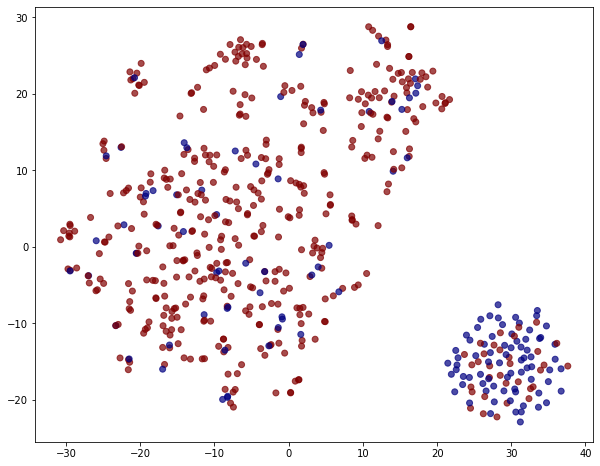

In [59]:
# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    patient_weighted_node_embeddings_2d[:, 0],
    patient_weighted_node_embeddings_2d[:, 1],
    c=patient_node_targets.cat.codes,
    cmap="jet",
    alpha=0.7,
)
plt.show()

In [60]:
patient_weighted_node_emb_dict = {}
for index, row in patient_square_node_data_no_feature.iterrows():
    if index not in patient_weighted_node_emb_dict:
        patient_weighted_node_emb_dict[index] = weighted_model_patient.wv[index]
    else:
        print(f"index: {index} is already in a dictionary!")

In [61]:
print(type(patient_weighted_node_emb_dict['aprv']))

<class 'numpy.ndarray'>


In [62]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

seed = 42
numpy.random.seed(seed)
tf.random.set_seed(seed)
sg.random.set_seed(seed)

### Load the data

In [63]:
from collections import defaultdict

def create_graph_list(patient_cooc_dict, cooc_odd_scores, node_emb_dict, label):
    
    graphs = []
    labels = []
    
    for key,row in patient_cooc_dict.items():
     
        if row:
            source = []
            target = []
            edge_weight = []
            
            node_feature = []
            node_idx = []
            for cooc in row:
                source.extend([cooc[0], cooc[1]])
                target.extend([cooc[1], cooc[0]])
                edge_weight.extend([cooc_odd_scores[cooc], cooc_odd_scores[cooc]])
        
            node_idx = list(set(source + target))
    
            # Create a dataframe of only nodes
            square_node_data = pd.DataFrame(
                index=node_idx)
            
#             square_node_data['feature'] = [1] * len(node_idx)
        
            # Create a dictionary for each column for a vector
            node_features = defaultdict(list)
            for node in node_idx:
                for i, vec in enumerate(node_emb_dict[node]):
                    node_features['w_' + str(i)].append(vec)
        
            # Add columns to a dataframe
            for k, v in node_features.items():
              
                square_node_data[k] = v

            square_edges = pd.DataFrame({ 
                "source": source, 
                "target": target, 
#                 "feature":edge_weight
            })
        
            square = StellarGraph({"corner": square_node_data}, {"line": square_edges})
            graphs.append(square)
            labels.append(label)
            
    return graphs, labels

graphs = []
labels = []

# patient_weighted_node_emb_dict
graph_0, label_0 = create_graph_list(patient_cooc_0, patient_cooc_odd_scores, patient_weighted_node_emb_dict, -1)
graph_1, label_1 = create_graph_list(patient_cooc_1, patient_cooc_odd_scores, patient_weighted_node_emb_dict, 1)

graphs.extend(graph_0)
labels.extend(label_0)
print(f"graphs_0: {len(graphs)}, labels_0: {len(labels)}")
graphs.extend(graph_1)
labels.extend(label_1)
print(f"graphs_1: {len(graph_1)}, labels_1: {len(label_1)}")
print(f"graphs: {len(graphs)}, labels: {len(labels)}")

graphs_0: 145, labels_0: 145
graphs_1: 642, labels_1: 642
graphs: 787, labels: 787


In [64]:
# prepare test and train datasets
test_cnt = int(len(graphs)*0.1)/2
print(test_cnt)

pos_start = len(graph_0)
print(pos_start)

test_arr = []
train_arr = []
for i, v in enumerate(graphs):
    # Take first items for neg set
    if i < test_cnt:
        test_arr.append(i)    
    elif i > pos_start and i <= pos_start + test_cnt:
        test_arr.append(i)    
    else:
        train_arr.append(i)

39.0
145


In [65]:
import random
seed = 42
c = list(test_arr)
random.Random(seed).shuffle(c)
test_arr =  c

In [66]:
c = list(train_arr)
random.Random(seed).shuffle(c)
train_arr =  c

In [67]:
train_index = np.array(train_arr)
test_index = np.array(test_arr)

In [68]:
print(len(test_index))
print(test_index)

78
[154 155 159   8 158 175  33  15 168 160 174 157 147 181 163  23  25   7
 167 164  36  18 172  19  20 149  30 169 165 173 150 170   2  16 166  22
 146  24   5   6 153 178   9 156  21 171 162  10   0 179  37 180 184  26
  34 151 148 152  12 182   1  38  32  29  27 177 183   4 161  11 176  13
  17  28  31  35   3  14]


In [69]:
print(len(train_index))
print(train_index)

709
[461 734 405 329 689 489 140 646 228 300  54 610 517 480  55 726  52 358
 113 432 502  67 664  78 417 653 576 603 287 258 464 341  44 705 125 544
 435 384 745 447 484 236 406 690 342 221 269 433 139  53 380 254 667 462
 309 250 418 715  63 634 725 626 665 252 661 299  41 144 470 437 574 635
 605 654 633 364 500  47 388 716 265 688 645 758  49 593 714  81 662 747
  75 343 193 290 514 278 291 563 333 350 545 655  72 604 459 475 368 494
 659 334 240 103 131 270 117 210 339 135  79 728 775 539 481 700 216 399
  97 276 102 477 196 722  95 641 438 419 227 505 518 704 778 263 145 340
 687 553 101 297 756 503 285 381 522 768  62 562 617 657 371  82 375 598
 631 398 456 197 404 706 386 315 515 413 731 255 394 218 268 116 601 579
 740 332 495 271 436 569 592 393 736 428 786 531 742 638 561 207 379 650
 695 615 781 751 482 527  56 188 541 530 249 266 458 262 402 625 469 490
 632 305 363 656 372 570 225 431 319 497 233 607 471 279 720 127 493 230
 560  48 429 226  84 389 559 478 759 346 513 21

In [70]:
print(graphs[0].info())

StellarGraph: Undirected multigraph
 Nodes: 18, Edges: 212

 Node types:
  corner: [18]
    Features: float32 vector, length 128
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [212]
        Weights: all 1 (default)
        Features: none


In [71]:
print(graphs[100].info())

StellarGraph: Undirected multigraph
 Nodes: 7, Edges: 26

 Node types:
  corner: [7]
    Features: float32 vector, length 128
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [26]
        Weights: all 1 (default)
        Features: none


In [72]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,787.0,787.0
mean,4.8,17.3
std,3.3,29.5
min,2.0,2.0
25%,2.0,2.0
50%,4.0,6.0
75%,6.0,18.0
max,22.0,272.0


In [73]:
graph_labels = pd.Series(labels)

In [74]:
print(graph_labels)

0     -1
1     -1
2     -1
3     -1
4     -1
      ..
782    1
783    1
784    1
785    1
786    1
Length: 787, dtype: int64


In [75]:
graph_labels.value_counts().to_frame()

,0
1,642
-1,145


In [76]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

In [77]:
print(type(graph_labels))

<class 'pandas.core.frame.DataFrame'>


In [78]:
graph_labels

,1
0,0
1,0
2,0
3,0
4,0
...,...
782,1
783,1
784,1
785,1


In [79]:
generator = PaddedGraphGenerator(graphs=graphs)

In [80]:
print(generator.__dir__())
print(generator.graphs[0])

['node_features_size', 'graphs', 'name', '__module__', '__doc__', '__init__', '_check_graphs', 'num_batch_dims', 'flow', '__abstractmethods__', '_abc_impl', 'default_corrupt_input_index_groups', '__dict__', '__weakref__', '__slots__', '__repr__', '__hash__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__new__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']


In [81]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])

    return model

In [82]:
epochs = 200  # maximum number of training epochs
# folds = 10  # the number of folds for k-fold cross validation
# n_repeats = 5  # the number of repeats for repeated k-fold cross validation

In [83]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

In [84]:
# To train in folds
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=0, callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

In [85]:
# To train in folds
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size, shuffle=False, seed=42
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size, shuffle=False, seed=42
    )

    return train_gen, test_gen

In [86]:
# To train in folds
test_accs = []

# stratified_folds = model_selection.RepeatedStratifiedKFold(
#     n_splits=folds, n_repeats=n_repeats
# ).split(graph_labels, graph_labels)

# for i, (train_index, test_index) in enumerate(stratified_folds):
for i in range(50):
    print(f"Training and evaluating on fold {i+1}...")
    
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_labels, batch_size=30
    )

    model = create_graph_classification_model(generator)

    history, acc = train_fold(model, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

Training and evaluating on fold 1...
Training and evaluating on fold 2...
Training and evaluating on fold 3...
Training and evaluating on fold 4...
Training and evaluating on fold 5...
Training and evaluating on fold 6...
Training and evaluating on fold 7...
Training and evaluating on fold 8...
Training and evaluating on fold 9...
Training and evaluating on fold 10...
Training and evaluating on fold 11...
Training and evaluating on fold 12...
Training and evaluating on fold 13...
Training and evaluating on fold 14...
Training and evaluating on fold 15...
Training and evaluating on fold 16...
Training and evaluating on fold 17...
Training and evaluating on fold 18...
Training and evaluating on fold 19...
Training and evaluating on fold 20...
Training and evaluating on fold 21...
Training and evaluating on fold 22...
Training and evaluating on fold 23...
Training and evaluating on fold 24...
Training and evaluating on fold 25...
Training and evaluating on fold 26...
Training and evaluati

In [87]:
# 1: Accuracy over all folds mean: 78.3% and std: 1.7%
# 2: Accuracy over all folds mean: 78.2% and std: 2.2%
# 3: Accuracy over all folds mean: 78.8% and std: 2.2%
# 4: Accuracy over all folds mean: 78.4% and std: 2.6%

# ---------- After setting random
# 1: Accuracy over all folds mean: 78.6% and std: 2.5%
# 2: Accuracy over all folds mean: 77.8% and std: 2.2%
# 3: Accuracy over all folds mean: 78.3% and std: 1.9%
# 4: Accuracy over all folds mean: 78.3% and std: 2.4%
# 5: Accuracy over all folds mean: 78.0% and std: 2.1%
# 6: Accuracy over all folds mean: 78.9% and std: 1.8%
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 79.3% and std: 1.9%


Text(0, 0.5, 'Count')

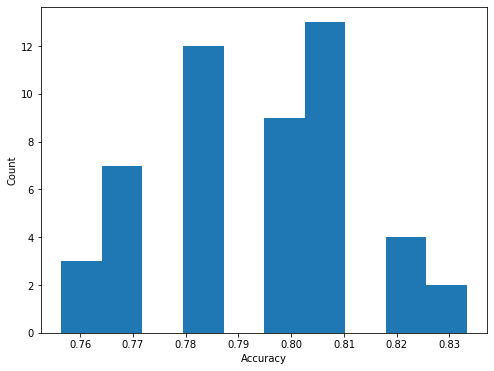

In [88]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

In [89]:
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 78.6% and std: 2.5%


Text(0, 0.5, 'Count')

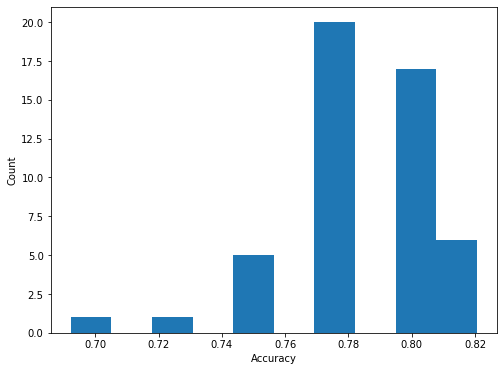

In [90]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

In [91]:
# 1: Accuracy over all folds mean: 78.6% and std: 2.5%
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 78.6% and std: 2.5%


Text(0, 0.5, 'Count')

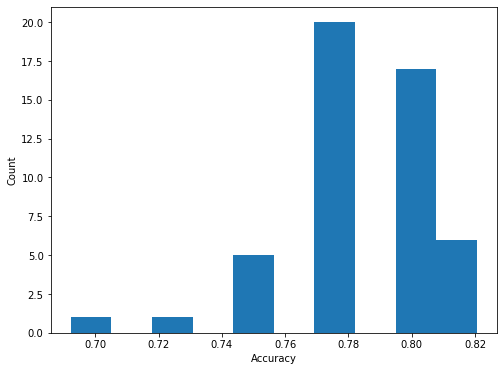

In [92]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

In [ ]:
# stratified_folds = model_selection.RepeatedStratifiedKFold(
#     n_splits=folds, n_repeats=n_repeats
# ).split(graph_labels, graph_labels)

# for i, (train_index, test_index) in enumerate(stratified_folds):
#     print(f"\ntrain_index: \n{train_index}\ntest_index: \n{test_index}\n")
#     break
# print(f"train: {len(train_index)}, test: {len(test_index)}")

In [109]:
print(test_gen.__dir__())


['name', 'graphs', 'selected_ilocs', 'normalize_adj', 'targets', 'batch_size', 'normalized_adjs', '_np_rs', 'shuffle', '__module__', '__doc__', '__init__', '_epoch_size', '__len__', '_pad_graphs', '__getitem__', 'on_epoch_end', '__iter__', '__dict__', '__weakref__', '_keras_api_names', '_keras_api_names_v1', '__repr__', '__hash__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__new__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']


In [113]:
print(len(test_gen.targets))

78


In [112]:
print(len(train_gen.targets))

709


In [142]:
print(train_gen.__getitem__(15))

([array([[[-2.91441679e-01, -2.73707747e-01, -1.09300360e-01, ...,
          1.11070704e-02,  2.42006615e-01,  7.41676986e-03],
        [-2.42728129e-01, -2.47191146e-01, -1.11892134e-01, ...,
         -2.16706470e-02,  6.01182804e-02,  1.65921450e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.65216193e-01,  2.03200594e-01, -1.37580037e-01, ...,
          4.63718355e-01,  2.81667084e-01,  1.20137110e-01],
        [-2.90383957e-02,  9.50797275e-02, -1.77608971e-02, ...,
          4.97027487e-01,  3.1202957

In [121]:
print(train_gen.targets)

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]


In [118]:
train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=40, shuffle=False, seed=42)
test_gen = generator.flow(
    test_index, targets=graph_labels.iloc[test_index].values, batch_size=40, shuffle=False, seed=42)

In [84]:
model_weighted = create_graph_classification_model(generator)

history = model_weighted.fit(
        train_gen, epochs=200, validation_data=test_gen, verbose=1, callbacks=[es])

Epoch 1/200
18/18 [==============================] - 1s 81ms/step - loss: 0.4634 - acc: 0.8152 - val_loss: 0.7549 - val_acc: 0.5000
Epoch 2/200
18/18 [==============================] - 1s 62ms/step - loss: 0.3957 - acc: 0.8505 - val_loss: 0.8541 - val_acc: 0.5000
Epoch 3/200
18/18 [==============================] - 1s 65ms/step - loss: 0.3671 - acc: 0.8505 - val_loss: 0.7820 - val_acc: 0.5000
Epoch 4/200
18/18 [==============================] - 1s 59ms/step - loss: 0.3529 - acc: 0.8505 - val_loss: 0.6780 - val_acc: 0.5000
Epoch 5/200
18/18 [==============================] - 1s 64ms/step - loss: 0.3469 - acc: 0.8505 - val_loss: 0.6897 - val_acc: 0.5000
Epoch 6/200
18/18 [==============================] - 1s 42ms/step - loss: 0.3351 - acc: 0.8505 - val_loss: 0.6749 - val_acc: 0.5000
Epoch 7/200
18/18 [==============================] - 1s 59ms/step - loss: 0.3500 - acc: 0.8505 - val_loss: 0.6619 - val_acc: 0.5000
Epoch 8/200
18/18 [==============================] - 0s 25ms/step - loss: 0.

In [85]:
# calculate performance on the test data and return along with history
# Node features 128 node2vec, edge features all 1
test_metrics = model_weighted.evaluate(test_gen, verbose=1)
test_acc = test_metrics[model_weighted.metrics_names.index("acc")]

2/2 [==============================] - 0s 3ms/step - loss: 0.4603 - acc: 0.7692


In [86]:
print(test_metrics)
#test loss, test acc: [0.44636884331703186, 0.7564102411270142]
# 2nd try: [0.39137980341911316, 0.7820512652397156]
# 3: [0.4521435499191284, 0.7564102411270142]
# 4: [0.437004417181015, 0.7948718070983887]
print(test_acc)

[0.46027061343193054, 0.7692307829856873]
0.7692307829856873


In [ ]:
print("Generate predictions for samples")
predictions = model_weighted.predict(test_gen, verbose=0)
print("predictions shape:", predictions.shape)
# predictions shape: (79, 1)
print(predictions)

In [ ]:
print(test_gen.targets)